<a href="https://colab.research.google.com/github/Justin-Qian/ML_Homework_Collection/blob/main/68510_Expression_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.8510 MiniProject 3: Expression Recognition

## Due Friday March 21 at 7pm

![alt text](https://i.pinimg.com/originals/56/be/63/56be63d62aa5b174bf9daa13a700a8d2.jpg)
Figure 1: Actress Scarlet Johansson making various face expressions.



## **1	Introduction**

The goal of this project is to explore the task of expression analysis and emotion classification over two different data sets: 2D images and 3D point clouds. You will implement and compare several neural network architectures, building on what you learned in Mini Project 2. In addition, you’ll get experience with Transfer Learning for creating personalized models. Please start early and ask questions!
The data sets you will use in this project are:

1) [Kaggle Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expressionrecognition-challenge/data)

2)	Personal face expression images generated by you

3)	Staff generated point clouds from the iPhone X True-Depth Camera Included with this project is iMotions’s “Facial Expression Analysis: The Complete Pocket Guide.” Use this as a reference throughout the project and please go through it before writing any code. It describes the anatomical characteristics of expression and shows examples of each type of expression.

The Facial Action Coding System (FACS) is a tool for measuring expressions first published in 1978 by Ekman and Friesen. It is an anatomical system for describing all observable face movement. It breaks down expressions into individual components of muscle movement known as Activation Units. In this section, we will ask you to describe Facial Expressions based on Activation Units from FACS. A complete guide to FACS and AUs can be found on [iMotions blog](https://imotions.com/blog/facial-action-coding-system/) .

## **2	Getting Started**

### 2.1 Guide to using Colab
Colab is a free Jupyter notebook environment by Google that runs entirely in the cloud. It does not require a setup and allows you to run code and see the output immediately (see [here](https://towardsdatascience.com/a-beginners-tutorial-to-jupyter-notebooks-1b2f8705888a) for more info on Jupyter notebooks and [here](https://www.tutorialspoint.com/google_colab/your_first_colab_notebook.htm) for a walkthrough of how Colab works).

Colab notebooks are automatically saved on your Google Drive account but can also be saved on a github account. For the purposes of this lab, you only need to know the very basics of using Jupyter notebooks (and by extension Colab).

**Coding Interface**
*   You will write your code directly into the code blocks in the notebook
*   To run your code, you can either press ctrl-enter when inside the cell, or click the run button in the upper left corner of the cell (need to hover over the brackets for it to appear).
*   In order for this lab to work correctly, you should run every cell in order (i.e., as you come upon a code cell, even if it's just staff code, please run it).
*   If a cell has been run, a number will appear in brackets in the upper left corner where the run button appears. This number helps you track the order of the calls.
*   You are welcome to add any new coding blocks you want (by clicking + Code in the top menu) but you cannot import any more libraries than the ones in this project

**Uploading files**
*   To upload files from your computer into the notebook (will be required later in the project), click the folder icon on the sidebar on the left. The upload button will let you select the file
*   File reading works the same as in a normal IDE. You have to specify the path to your file if it is inside a folder vs. in the main file area.
*   Everytime Colab is closed (or refreshed), uploaded files are removed and must be re-uploaded.

**Saving files**

You will be saving some trained models in this mini project to include in your submission. We suggest that each time you save a model, you also download it to your local machine. Saved files are removed if Colab is closed or refreshed, so you may want to download them just in case.


### 2.2 Colab Environment Setup

**IMPORTANT: Ensure you are using a GPU by going into the file menu above: Runtime -> Change Runtime Type -> GPU**

#### Importing Data
We will be pulling in two datasets for this mini project. The Kaggle data set is located in kaggle fer2013/fer2013.csv. There are 28K training and 3K testing images in the dataset, each composed of a 48x48 square of pixels and labeled with an emotion [0-6] (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The iPhone X dataset is located in iPhoneX/faces.py. There are samples of 50 subjects posing with 7 different expressions. Each sample consists of 1220 (x, y, z) points to make up a depth map. We’ll explore this data more in Section 5.

The data will be pulled into a folder names mp4_data

In [ ]:
! git clone  https://gitlab.com/andwong/mp4_data.git

Cloning into 'mp4_data'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 3), reused 22 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 93.64 MiB | 18.25 MiB/s, done.
Resolving deltas: 100% (3/3), done.


#### Setting up imports

The output will mention package incompatibilities - do not worry about this, it is just to do with some inconsistencies in the version of Tensorflow we are using.

In [ ]:
%pip install 'h5py==2.10.0' --force-reinstall

import keras
from keras.preprocessing import image

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D

import numpy as np

import matplotlib
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for h5py
  Running setup.py clean for h5py
Failed to build h5py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (h5py)


#### Predefined Staff Variables/Functions

In [ ]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

def plot_emotion_prediction(pred):
    """
    Plots the prediction for each emotion on a bar chart
    :param pred: the predictions for each emotions
    """
    labels = np.arange(len(emotions))
    plt.bar(labels, pred, align='center', alpha=0.5)
    plt.xticks(labels, emotions)
    plt.ylabel('prediction')
    plt.title('emotion')
    plt.show()

### 2.3 Mini Project Structure

In this miniproject, you will

1) 	Code a Convolutional Neural Network using Keras to detect Face Expressions from a large dataset of images

2)	Use transfer learning to adapt the CNN you’ve created into a personalized network for your own expressions (you’ll have to supply the data)

3)	Explore a new type of available face data - point clouds from the iPhone X True Depth Camera and classify samples by modifying your original CNN.

Please do not hesitate to post for help on Piazza using the miniproject3 tag.

## **3	Expression Recognition with Convolutional Neural Networks**
As you read about and saw during the lecture on face recognition, the hidden layers of a Convolutional Neural Network (CNN) typically consist of some combination of convolutional layers, pooling layers, fully connected layers and normalization layers. We’ll give a brief overview of the CNNs and what these layers do. If you don’t have any experience with CNNs, watch [this video](https://www.youtube.com/watch?v=YRhxdVk_sIs) on YouTube to get a solid understanding of how they function.

Together, we’ll code up a simple CNN to process the Kaggle dataset. You are encouraged to improve this model by adding additional layers. The Input layer will take in image data (represented as a matrix of numbers) and pass them into a convolution layer. Here the image data is “convolved” - a filter (i.e., a function) is applied methodically to overlapping tiles of the input. The values the filter produces (technically, the dot product of the filter with each sub matrix, is itself another matrix of data. The final layer, the fully connected layer, takes the convolution and produces a vector of predictions.

Now it’s time to write a CNN using the Keras API and Tensorflow backend. We’ve already started an implementation for you below. You should complete the implementation by following these steps:

###Part A
We need to understand our input before we can begin our model. The Kaggle dataset contains 35888 images: 28709 for training and 3589 for testing. Let’s organize this data so we can use it in out model.

The supplied code imports the data from the .csv file for you. Each line of data contains an emotion label, image data, and test/train usage. The emotion label is a number between 0 and 6, corresponding to the labels specified above.

1) We parse the .csv file for you into x train, the training image pixel data as 1D arrays of pixels, y train, the labels corresponding to the training images, x test, the testing image pixel data as 1D arrays of pixels, y test, the labels corresponding to the test images. You will need to do this on your own later in the mini project

2)	The pixel values in the image data are strings. Convert them to float32 and normalize the inputs to be between 0 and 1 (where the image data is on the scale [0, 255]).


3) Reshape the image data so we can enter samples into our modes with the shape (48, 48, 1).

In [ ]:
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 5

def split_data():
  # READ IN KAGGLE DATA
  with open("mp4_data/kaggle_fer2013/fer2013.csv") as file:
      data = file.readlines()

  lines = np.array(data)

  x_train, y_train, x_test, y_test = [], [], [], []

  # A. 1) SPLIT DATA INTO TEST AND TRAIN
  for i in range(1,lines.size):
      emotion, img, usage = lines[i].split(",")
      val = img.split(" ")
      pixels = np.array(val, 'float32')
      emotion = keras.utils.to_categorical(emotion, num_classes)

      if 'Training' in usage:
          y_train.append(emotion)
          x_train.append(pixels)
      elif 'PublicTest' in usage:
          y_test.append(emotion)
          x_test.append(pixels)

  # A. 2) CAST AND NORMALIZE DATA
  normalized_train_list = [arr / 255.0 for arr in x_train]
  normalized_test_list = [arr / 255.0 for arr in x_test]

  # A. 3) RESHAPE DATA
  x_train = [arr.reshape(48, 48, 1) for arr in normalized_train_list]
  x_test = [arr.reshape(48, 48, 1) for arr in normalized_test_list]

  x_train = np.array(x_train)
  y_train = np.array(y_train)
  x_test = np.array(x_test)
  y_test = np.array(y_test)

  return x_train, y_train, x_test, y_test


### Part B
Now it’s time to code the CNN. We’ll make use of the Keras functional API for building models. For more information on Keras, see the Keras Tutorial online and explore the documentation [here](https://keras.io/getting-started/functional-api-guide/) . We’ll create a simple model together that gives you a working solution. However, we will later expect you to add additional layers to this model to improve its performance.

1)	Create an Input layer that takes in data of shape (48, 48, 1, ). This is the size of our photos

2)	Add a Convolutional layer to the network using the 2D convolution layer for spatial convolution over images. Make sure the layer has the following properties: filters=64., kernel_size=(5,5), activation=‘relu’

3)	Add a MaxPooling2D layer with pool_size=(5,5) and strides=(2, 2)

4)	Add a Flatten layer which converts the data into a 1D feature vector ready for classification

5)	Add a Dense layer with 1024 units and activation=‘relu’

6)	Add a final Dense layer with 7 units (for classification) and the ‘softmax’ activation function

In [ ]:
# B. CREATE CNN MODEL

def create_model():
  inputs = Input(shape=(48, 48, 1, ))
  # INSERT LAYERS HERE
  x = Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(inputs)
  x = MaxPooling2D(pool_size=(5, 5), strides=(2, 2))(x)
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  outputs = Dense(7, activation='softmax')(x)

  return Model(inputs, outputs)

### Part C
Now it’s time to train our model and see how well it performs.

1) Compile your model with loss=‘categorical_crossentropy’ and the Adam optimizer (i.e. keras.optimizers.Adam()).

2) Train your model by calling model.fit (...) and the provided steps_per_epoch = batch size and epochs = 5 variables. Ensure that you batch the training and testing data in the Model.fit(..., batch  size = 256) method.

3) Make sure to save your model after training it: export the model to a .h5 file using the built in model.save(‘model 1.h5’) (please use this naming convention). The model should take about 10 minutes to run and should achieve about 55% accuracy.

**Note: you may want to download the model to your local machine just incase Colab crashes or unexpectedly closes. You can download by right-clicking on the model in the file sidebar and selecting download**

In [ ]:
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = steps_per_epoch = 256
epochs = 5

def cnn():
  x_train, y_train, x_test, y_test = split_data()
  model = create_model()

  # C. 1) COMPILE MODEL
  model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

  # C. 2) DATA BATCH; TRAIN AND SAVE MODEL
  model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs
    )

  model.save('model_1.h5')

cnn()


Epoch 1/5
113/256 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2332 - loss: 2.4561

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


256/256 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.2614 - loss: 2.1644 - val_accuracy: 0.3842 - val_loss: 1.6129
Epoch 2/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4089 - loss: 1.5467 - val_accuracy: 0.4361 - val_loss: 1.4943
Epoch 3/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4603 - loss: 1.4225 - val_accuracy: 0.4737 - val_loss: 1.4018
Epoch 4/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.4883 - loss: 1.3462 - val_accuracy: 0.4553 - val_loss: 1.4131
Epoch 5/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5213 - loss: 1.2701 - val_accuracy: 0.4787 - val_loss: 1.3674


4) You can test your model with the script below to see how a certain example (jackman.png) gets classified.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


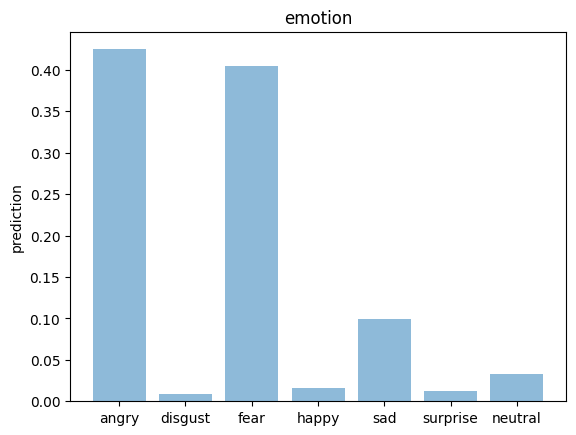

In [ ]:
def test_cnn():
  model = load_model('model_1.h5')

  img = image.load_img("mp4_data/jackman.png", color_mode = "grayscale", target_size=(48, 48))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  x /= 255

  custom = model.predict(x)
  plot_emotion_prediction(custom[0])

test_cnn()

### Part D

Now, modify the model to improve your accuracy. You may change the parameters (such as batch size) and layers of the model. We've provided new code blocks below for you to experiment in (you can copy over your code from part C).

 In your writeup, include:

*   A diagram of your final network architecture
*   A description of the structure and the parameters you used.
*   The accuracy and loss for your model

In the original Kaggle challenge, the winner achieved just 34% accuracy - so congrats, your model is already much better! Be sure to save your trained model as model_2.h5, i.e., following our naming convention.

**Ensure you are using a GPU by going into the file menu above: Runtime -> Change Runtime Type -> GPU (not TPU). If it was not selected, re-run all the code up to this point.**


In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 64
steps_per_epoch = 28709 // batch_size
epochs = 20

def create_model():
  inputs = Input(shape=(48, 48, 1, ))
  # INSERT LAYERS HERE
  # Layer1
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  # Layer2
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)

  x = Flatten()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)

  outputs = Dense(7, activation='softmax')(x)

  return Model(inputs, outputs)

def cnn():
  x_train, y_train, x_test, y_test = split_data()
  model = create_model()

  # Add an early stopping mechanism
  early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
  )

  # C. 1) COMPILE MODEL
  model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

  # C. 2) DATA BATCH; TRAIN AND SAVE MODEL
  history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=[early_stop]
    )

  best_epoch = np.argmin(history.history['val_loss']) + 1
  best_val_acc = history.history['val_accuracy'][best_epoch - 1]
  print(f"✨ Best epoch: {best_epoch}")
  print(f"✅ Validation accuracy at best epoch: {best_val_acc:.4f}")

  model.save('model_2.h5')

cnn()

Epoch 1/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.2930 - loss: 1.7581 - val_accuracy: 0.4416 - val_loss: 1.4562
Epoch 2/20
  1/448 ━━━━━━━━━━━━━━━━━━━━ 14:02 2s/step - accuracy: 0.3514 - loss: 1.7240

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 631us/step - accuracy: 0.3514 - loss: 1.7240 - val_accuracy: 0.4452 - val_loss: 1.4522
Epoch 3/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.4467 - loss: 1.4433 - val_accuracy: 0.4937 - val_loss: 1.3380
Epoch 4/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.4054 - loss: 1.5582 - val_accuracy: 0.4962 - val_loss: 1.3385
Epoch 5/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5055 - loss: 1.3035 - val_accuracy: 0.4987 - val_loss: 1.2881
Epoch 6/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.4595 - loss: 1.1151 - val_accuracy: 0.4979 - val_loss: 1.2890
Epoch 7/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5359 - loss: 1.2221 - val_accuracy: 0.5213 - val_loss: 1.2494
Epoch 8/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.5946 - loss: 1.0694 - val_accuracy: 0.5199 - val_loss: 1.2477
Epoch 9/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5738 - loss: 1.1300 - val_accuracy:

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


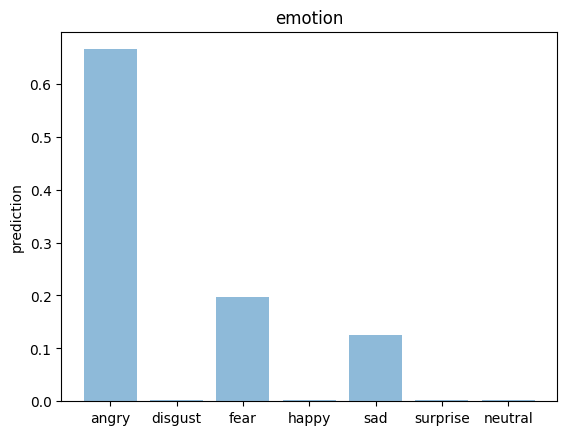

In [ ]:
def test_cnn():
  model = load_model('model_2.h5')

  img = image.load_img("mp4_data/jackman.png", color_mode = "grayscale", target_size=(48, 48))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  x /= 255

  custom = model.predict(x)
  plot_emotion_prediction(custom[0])

test_cnn()

##4	Transfer Learning for a Personalized Machine Learning Model

In practice, very few people train an entire Convolutional Network from scratch (with random initialization) as we just did. This is because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pre-train a CNN on a (different) very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

The process of sharing results across different problems is known as Transfer Learning. In other words, Transfer Learning is a machine learning technique where a model trained on one task is re-purposed for a second related task.

In the section, we’ll first ask you to generate your own expression data (yes, you’ll have to take pictures of yourself) and use that data to fine-tune your CNN from the previous section into a personalized model for your face, using Transfer Learning.

###Part E
Pose in front of a camera or get a friend to help you take 7 pictures: one for each type of expression: angry, disgust, fear, happy, sad, surprise, neutral. This is your training data. Crop these images so that they contain a bounding box of only your face. It is OK if the pictures are not 48 x 48, Keras will resize them.

###Part F
Take 7 more pictures. This is your testing data.

Add your training and testing images to the notebook:

1) Open the files section of the sidebar on the left side of your screen

2) Right-click in the area to open the context menu. Select create new folder.

3) Upload your images (you can upload multiple at a time)

4) Structure the folder and name your images as you like

###Part G
Now it’s time to load your model from the previous section. We’ve started an implementation for you below.

1) Import the data from your images and reshape the data so that you can retrain your model from Section 3 (model 2.h5). You will need to grayscale your images. You may find functions in keras.preprocessing useful for image manipulation.

2) Load your model using load_model(‘model_2.h5’) and train the model on your 7 training images.

3) Finally, test the newly trained model on your test images. Save your trained model as model_3.h5. Remember we provided the helper function plot_emotion_prediction(pred) at the beginning of this notebook that takes in a model prediction values from a single call of model.predict(x) and plots them on a bar graph.

In [ ]:
import zipfile

with zipfile.ZipFile("images.zip", 'r') as zip_ref:
    zip_ref.extractall("images")

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import os

In [ ]:
def test_cnn(model_path, img_path):
  model = load_model(model_path)

  img = image.load_img(img_path, color_mode = "grayscale", target_size=(48, 48))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  x /= 255

  custom = model.predict(x)
  plot_emotion_prediction(custom[0])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step - accuracy: 0.1405 - loss: 4.0554
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1976 - loss: 4.1343    
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1976 - loss: 3.2150    
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1405 - loss: 2.3363    
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1476 - loss: 2.4649    
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2810 - loss: 2.8890    
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1476 - loss: 2.4362    
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2976 - loss: 2.4821
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2310 - loss: 2.4909    
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6119 - loss: 1.1815
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5786 - loss: 1.5717
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


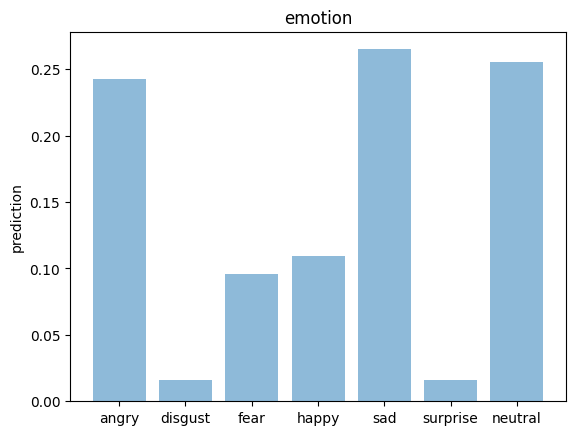

In [ ]:
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 2
epochs = 50

def transfer():
  # G. 1) Import data and reshape data
  train_path = "images/train"
  test_path = "images/test"

  img_size = (48, 48)

  def load_images_from_folder(folder):
    x = []
    y = []
    for label in range(num_classes):
        img_path = os.path.join(folder, f"{label}.jpg")
        img = load_img(img_path, color_mode="grayscale", target_size=img_size)
        img_array = img_to_array(img) / 255.0
        x.append(img_array)
        y.append(label)
    return np.array(x), to_categorical(y, num_classes)

  x_train, y_train = load_images_from_folder(train_path)
  x_test, y_test = load_images_from_folder(test_path) #test folder is not organized

  # G. 2) Load model and train on training images
  model = load_model('model_2.h5')

  for layer in model.layers[:2]:
    layer.trainable = False

  model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

  early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

  history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[early_stop])

  model.save("model_3.h5")

  # G. 3) Test newly trained model and save
  model_path = "model_3.h5"
  img_path = "images/test/0.jpg"
  test_cnn(model_path, img_path)

transfer()

In [ ]:
def compare():
    test_path = "images/test"
    img_size = (48, 48)

    model_before = load_model('model_2.h5')
    model_after = load_model('model_3.h5')

    print(f"{'Label':<6}{'Before':<10}{'After':<10}{'Match Before':<15}{'Match After'}")
    print("-" * 50)

    for i in range(7):  # 0~6
        img_file = os.path.join(test_path, f"{i}.jpg")
        img = load_img(img_file, color_mode="grayscale", target_size=img_size)
        x = img_to_array(img) / 255.0
        x = np.expand_dims(x, axis=0)

        pred_before = model_before.predict(x, verbose=0)
        pred_after = model_after.predict(x, verbose=0)

        pred_before_label = np.argmax(pred_before[0])
        pred_after_label = np.argmax(pred_after[0])

        print(f"{i:<6}{emotions[pred_before_label]:<10}{emotions[pred_after_label]:<10}{str(pred_before_label==i):<15}{str(pred_after_label==i)}")

compare()

Label Before    After     Match Before   Match After
--------------------------------------------------
0     happy     angry     False          True
1     happy     happy     False          False
2     neutral   sad       False          False
3     happy     happy     True           True
4     happy     sad       False          True
5     neutral   sad       False          False
6     neutral   sad       True           False


4)  Which expressions are not being recognized? Why do you think some expressions are recognized better than others? Report the accuracy of the model.

5) If your model did not achieve good accuracy on your personal data, explain why you think that is.

## 5	From Images to Depth: Next Generation of Face Representation
In this section, we expect you to implement a fully functional model on your own. Your work in this part will be graded on correctness, not on how accurate your final model is.

Recall structured light: the technology used by the Xbox Kinect that shines thousands of infrared dots in an area and can create a corresponding depth map. The iPhone X also uses this technology to scan a user’s face. We’ve accumulated samples of 100 iPhone X users posing with different face expressions using [Apple’s ARKit framework](https://developer.apple.com/documentation/arkit/arfaceanchor?language=objc) . Apple anchors the face into a specific origin, and provides us with vertex positions for each point in the face mesh. These vertices are referred to as a point cloud. The point cloud we receive is sparse, so we see a smoothed version of an actual face. Together, this normalizes all of our data and makes it ready for analysis.

![alt text](https://www.bing.com/th?id=OIP.nxQY5PjyWSCBU1oYGGqy3AHaDS&pid=Api&rs=1)

Figure 2: Origin of the face coordinate system.


In this last part, we’ll classify the 3D data into the same 7 emotions: angry, disgust, fear, happy, sad, surprise, neutral. However, this time we’re expecting you to craft the model. The model you will create should be a 3D Convolutional Neural Network. They are the same in essence to 2D CNNs, but perform operations in 3 dimensions. In order to use a 3D CNN, we’ll have to transform our input data into voxels. Voxels are the three-dimensional analogue of a pixel:
unit volumes of space that contain a value.


### Part H
To visualize the various expressions, you will need to use the Visualization GUI we provided in the zip file for you to run on your local machine. To use the GUI, run

```
python show_gui.py
```


You’ll be able to see the 7 different expressions. You can drag the graph to view the data from different orientations.



1) Inspect the 3D face data and give us your impressions. Compare the expression data using FACS. Which expressions are the most unique? Which expressions are most similar? What information does the point cloud provide us that the image does not?



Now it's time to try your hand at making your own model here in Colab! The data is provided as a Python dictionary

```
face_samples = { sample id : { emotion: { x: [...], y: [...], z: [...]}}}
```

2)  Read in the iPhone X data. For each point cloud, create a 24 x 24 x 24 voxel grid represented as a 3D numpy array initialized with all 0s. For each point in the cloud, increment the value of the voxel that the point falls in.

3) Construct a 3D Convolution Neural Network using Keras. You can use your previous work as a starting point, but will have to make use of Conv3D and MaxPool3D from Keras. You are free to add as many layers as you’d like.

4) Train and test your model. Save your trained model as model_4.h5.


In [ ]:
# H. 2) READ IN iPHONE X DATA AND SHAPE
%run mp4_data/iPhoneX/faces.py

In [ ]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
emotion_to_label = {emo: i for i, emo in enumerate(emotions)}

def pointcloud_to_voxel(emotion_cloud, grid_size=24):
    x = np.array(emotion_cloud['x'])
    y = np.array(emotion_cloud['y'])
    z = np.array(emotion_cloud['z'])

    # Normalized
    x_norm = (x - x.min()) / (x.max() - x.min() + 1e-8)
    y_norm = (y - y.min()) / (y.max() - y.min() + 1e-8)
    z_norm = (z - z.min()) / (z.max() - z.min() + 1e-8)

    # Mapping
    xi = np.clip((x_norm * (grid_size - 1)).astype(int), 0, grid_size - 1)
    yi = np.clip((y_norm * (grid_size - 1)).astype(int), 0, grid_size - 1)
    zi = np.clip((z_norm * (grid_size - 1)).astype(int), 0, grid_size - 1)

    # Initialization
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.int32)

    # Incrementation
    for i in range(len(xi)):
        voxel_grid[xi[i], yi[i], zi[i]] += 1

    return voxel_grid

x = []
y = []

for sample_id, emotions in face_samples.items():
    for emotion_name, cloud in emotions.items():
        voxel = pointcloud_to_voxel(cloud, grid_size=24)
        x.append(voxel)
        y.append(emotion_to_label[emotion_name])

In [ ]:
x = np.array(x).reshape(-1, 24, 24, 24, 1)
y = keras.utils.to_categorical(y, num_classes=7)

print("x shape:", x.shape)  # (N, 24, 24, 24, 1)
print("y shape:", y.shape)  # (N, 7)
print("y[0] =", y[0])       # 如：[0. 0. 0. 1. 0. 0. 0.] -> happy

x shape: (49, 24, 24, 24, 1)
y shape: (49, 7)
y[0] = [1. 0. 0. 0. 0. 0. 0.]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# H. 3) CREATE MODEL OF CHOICE
def create_model_3d():
    inputs = Input(shape=(24, 24, 24, 1))  # 和你的 x 数据 shape 对应

    # Layer 1
    x = Conv3D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling3D(pool_size=2)(x)  # 输出 -> (12, 12, 12, 32)

    # Layer 2
    x = Conv3D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=2)(x)  # 输出 -> (6, 6, 6, 64)

    # Layer 3
    x = Conv3D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=2)(x)  # 输出 -> (3, 3, 3, 128)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)

    outputs = Dense(7, activation='softmax')(x)

    return Model(inputs, outputs)

In [ ]:
# H. 4) TRAIN AND TEST MODEL. SAVE AS model_4.h5
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 12
epochs = 100

def train_3d_cnn(x, y):
    model = create_model_3d()

    # Early stopping
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    model.compile(
        optimizer=Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        x, y,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stop]
    )

    # Early Stop Parameters
    best_epoch = np.argmin(history.history['val_loss']) + 1
    best_val_acc = history.history['val_accuracy'][best_epoch - 1]
    print(f"✨ Best epoch: {best_epoch}")
    print(f"✅ Validation accuracy at best epoch: {best_val_acc:.4f}")

    model.save('model_4.h5')

train_3d_cnn(x, y)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 597ms/step - accuracy: 0.1049 - loss: 2.0661 - val_accuracy: 0.5000 - val_loss: 1.8810
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2368 - loss: 1.9060 - val_accuracy: 0.2000 - val_loss: 1.8916
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2442 - loss: 1.8978 - val_accuracy: 0.5000 - val_loss: 1.8510
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2090 - loss: 1.8422 - val_accuracy: 0.3000 - val_loss: 1.8065
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3761 - loss: 1.7918 - val_accuracy: 0.4000 - val_loss: 1.7771
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3872 - loss: 1.7206 - val_accuracy: 0.3000 - val_loss: 1.7529
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4419 - loss: 1.7292 - val_accuracy: 0.5000 - val_loss: 1.7327
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4579 - loss: 1.6666 - val_accuracy: 0.5000 - val_loss

✨ Best epoch: 52
✅ Validation accuracy at best epoch: 0.9000


5) In your writeup, include:

*   A diagram of your final network architecture
*   A description of the structure
*   The test/train ratio
*   The parameters you used (batch size, number of epochs)
*   The accuracy and loss for your model


## Extra Credit
###Extra Credit 1 (5 points):
Continue to modify your model until you achieve an accuracy >= 90%. Save your model as model_ec1.h5.



In [ ]:
# EC. 1) Accuracy >= 90%


###Extra Credit 2 (10 points maximum):
Use a different classification technique to classify the data (it does not have to be deep learning). Describe what you built and report how well your classification works. Be sure to include where you found inspiration for the implementation and what additional libraries you used

In [ ]:
# EC. 2) Different Classification Technique

## Exporting your Colab Notebook for Submission

Once you're done implmenting all the parts of the project, you will need to download your Colab Notebook and models to include as part of your submission.

1) For each model you saved, download it by right-clicking on it in the files and selecting download.

2) To download the notebook, click *download .ipynb* in the file menu.
